Twoim zadaniem jest wytrenowanie klasyfikatora binarnego na podzbiorze zbioru MNIST, w którym wyróżniamy klasy (cyfry 0 i 1 mają zostać wyłączone ze zbioru):
 - Liczby pierwsze (2,3,5,7)
 - Liczby złożone (4,6,8,9)

Napisz wydajną implementację modelu **regresji logistycznej** trenowanego algorytmem ***SGD z momentum***. Cały proces trenowania musisz napisać samodzielnie, w języku Python, korzystając z biblioteki numpy. Na potrzeby zadania niedozwolone jest korzystanie z gotowych implementacji optimizerów i modeli oraz bibliotek do automatycznego różniczkowania funkcji (np. Tensorflow, pytorch, autograd). 

Dobierz hiperparametry tak, aby uzyskać jak najlepszy wynik na zbiorze walidacyjnym. 
Wyciągnij i zapisz wnioski z przeprowadzonych eksperymentów.

Zbiór MNIST dostępny jest pod linkami: 

(zbiór treningowy):
 - http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
 - http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz

(zbiór walidacyjny):
 - http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
 - http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

Import dataset and reshape it

In [1]:
import numpy as np

data = np.fromfile(file='train-images-idx3-ubyte',dtype=np.uint8)
X_train = data[16:].reshape((60000,28*28)).astype(np.float128)

data = np.fromfile(file='train-labels-idx1-ubyte',dtype=np.uint8)
y_train = np.asarray(data[8:].reshape(60000))

data = np.fromfile(file='t10k-images-idx3-ubyte',dtype=np.uint8)
X_test = data[16:].reshape((10000,28*28)).astype(np.float128)

data = np.fromfile(file='t10k-labels-idx1-ubyte',dtype=np.uint8)
y_test = np.asarray(data[8:].reshape(10000))

Remove (0,1) values and change labels: (2,3,5,7) = 0, (4,6,8,9) = 1

In [2]:
def drop_zero_one(X, y):
    indexes = []
    for i in range(len(y)):
        if y[i] in [0,1]:
            indexes.append(i)
    X = np.delete(X, indexes, axis=0)
    return X.reshape((-1,28*28)), np.delete(y, indexes)

X_train_drop, y_train_drop = drop_zero_one(X_train, y_train)
X_test_drop, y_test_drop = drop_zero_one(X_test, y_test)

n_samples_train = len(y_train_drop)
n_samples_test = len(y_test_drop)

for i in range(n_samples_train):
    y_train_drop[i]  = y_train_drop[i] in [4,6,8,9]

for i in range(n_samples_test):
    y_test_drop[i] =  y_test_drop[i] in [4,6,8,9]

# Logistic Regression using Stochastic Gradient Descend with Momentum.

In order to reach best results on our validation set, there is also adaptive gradient (Adagrad) improvement included.

In [3]:
class SGD_logistic_regression:

    def __init__(self, n_epochs: int=10, learning_rate: float=0.1, momentum_const: float=0, adagrad: bool=False,
                 save_accuracy_values: bool=False, save_cost_values: bool=False, numerical_epsilon: float=1e-7,
                 momentum_alpha: float=-1, tolerance: float=0, shuffle_indexes=True):
        """
        :param n_epochs:    sets number of epochs during the learning process

        :param learning_rate:   sets learning rate of SGD

        :param momentum_const:  sets the value by which the previous velocity is multiplied, within the
                                momentum algorithm

        :param momentum_alpha: sets the value by which the gradient is multiplied within momentum-velocity formula

        :param adagrad:     value decides if model should use adaptive gradient, or not

        :param save_accuracy_values:    value decides if model should save computed accuracy
                                    values. If it's set as True, learning process becomes slower

        :param save_cost_values:    value decides if model should save computed loss function
                                    values. If it's set as True, learning process becomes slower

        :param numerical_epsilon:   usually small value, that helps to avoid computing errors
                                    (mostly inside exp, and log functions)

        :param tolerance:   value describes tolerance of loss function. If difference between
                            previous loss and current loss is smaller than tolerance param,
                            the learning process stops
        """

        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.momentum_const = momentum_const
        self.save_accuracy_value = save_accuracy_values
        self.save_cost_value = save_cost_values
        self.accuracy_values = []
        self.cost_values = []
        self.adagrad = adagrad
        self.numerical_epsilon = numerical_epsilon
        self.tolerance = tolerance
        self.shuffle_indexes = shuffle_indexes
        if momentum_alpha == -1:
            self.momentum_alpha = 1 - self.momentum_const
        else:
            self.momentum_alpha = momentum_alpha

    def add_bias(self, X: np.ndarray) -> np.ndarray:

        """adds intercept x0 = 1 to each instance"""
        return np.c_[np.ones((len(X),1)), X]

    def sigma(self, t: np.ndarray):
        """sigmoid function"""
        return 1/(1+np.exp(-t + 1 + self.numerical_epsilon))

    def normalize(self, X: np.ndarray, axis: int=-1, order: int=2) -> np.ndarray:
        """
        normalization of X parameter
        :param X:       normalized matrix
        
        :param axis:    if axis is an integer, it specifies the axis of X along
                        which to compute the vector norms
        
        :param order:   order of norm
        
        :return: X normalized with 'order' norm by 'axis' axis
        """
        normed = np.atleast_1d(np.linalg.norm(X, order, axis))
        normed[normed==0] = self.numerical_epsilon
        return X / np.expand_dims(normed, axis)

    def predict_probs(self, X: np.ndarray) -> np.ndarray:
        """predicts  probability of belonging to positive class"""
        return self.sigma(X.dot(self.theta))

    def predict(self, X: np.ndarray) -> np.ndarray:
        """predict if X instances belong to positive or negative class"""
        X = self.normalize(self.add_bias(X))
        return self.predict_probs(X) >= 0.5

    def loss(self, h, y):
        """
        cost function
        :param h:   probability of belonging to positive class
        
        :param y:   real label
        
        :return:    cost which defines quality of fit
        """
        return -(y.dot(np.log(h + self.numerical_epsilon)) + (1 - y).dot(np.log(1 - h + self.numerical_epsilon))).mean()

    @staticmethod
    def evaluate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """
        function computes accuracy of pointed label sets
        :param y_true:    real labels
        
        :param y_pred:    predicted labels
        
        :return:    accuracy based on passed parameters
        """
        true_pos = 0
        true_neg = 0
        for i in range(len(y_true)):
            if y_true[i] == y_pred[i] == 0:
                true_neg += 1
            elif y_true[i] == y_pred[i] == 1:
                true_pos += 1
        return (true_pos + true_neg)/len(y_true)

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        
        """fitting function"""
        #initializing staring values
        X_plus_bias = self.normalize(self.add_bias(X))
        self.theta = np.random.randn(X_plus_bias.shape[-1], 1)
        velocity = np.zeros((X_plus_bias.shape[-1], 1))
        squared_gradients = np.zeros((X_plus_bias.shape[-1],1))
        train_size = len(X)
        prev_accuracy = 0
        best_accuracy = 0
        best_theta = 0

        for epoch in range(self.n_epochs):
            if self.shuffle_indexes:
                indexes = np.random.permutation(range(train_size))
            else:
                indexes = range(train_size)
            for i in indexes:
                xi = X_plus_bias[i: i+1]
                yi = y[i]
                y_probability =  self.sigma(xi.dot(self.theta))

                #adaptive gradient improvement
                gradient = xi.T.dot(y_probability - yi)
                if self.adagrad:
                    squared_gradients += gradient**2
                    adjusted_gradient = gradient / np.sqrt(squared_gradients + self.numerical_epsilon)
                else:
                    adjusted_gradient = gradient

                #momentum - velocity value
                velocity = velocity * self.momentum_const + self.momentum_alpha*adjusted_gradient
                self.theta = self.theta - self.learning_rate * velocity

                #saving accuracy values
                if self.save_accuracy_value and i < 50 and epoch < 1:
                    y_pred = self.predict(X)
                    self.accuracy_values.append(SGD_logistic_regression.evaluate(y, y_pred))

            #after each epoch check if accuracy change is greater than the tolerance param
            #and if current result is better that the best by now
            y_pred = self.predict(X)
            curr_accuracy = SGD_logistic_regression.evaluate(y, y_pred)
            if curr_accuracy > best_accuracy:
                best_theta = self.theta
                best_accuracy = curr_accuracy

            if abs(curr_accuracy - prev_accuracy) < self.tolerance:
                break
            else:
                prev_accuracy = curr_accuracy

        self.theta = best_theta

Here we'll train some different models and check how they manage.

In [4]:
model_no_momentum = SGD_logistic_regression(n_epochs=1, learning_rate=0.12, save_accuracy_values=True, momentum_alpha=0.3)
model_no_momentum.fit(X_train_drop, y_train_drop)
y_pred1 = model_no_momentum.predict(X_test_drop)
print('Accuracy of model without Momentum: ', SGD_logistic_regression.evaluate(y_test_drop, y_pred1))

model_momentum = SGD_logistic_regression(n_epochs=1, learning_rate=0.12, save_accuracy_values=True, momentum_alpha=0.3,
                                         momentum_const=0.9)
model_momentum.fit(X_train_drop, y_train_drop)
y_pred2 = model_momentum.predict(X_test_drop)
print('Accuracy of model with Momentum: ', SGD_logistic_regression.evaluate(y_test_drop, y_pred2))

model_momentum_adagrad = SGD_logistic_regression(n_epochs=1, learning_rate=0.12, save_accuracy_values=True, momentum_alpha=0.3,
                                                 momentum_const=0.9, adagrad=True)
model_momentum_adagrad.fit(X_train_drop, y_train_drop)
y_pred3 = model_momentum_adagrad.predict(X_test_drop)
print('Accuracy of model with Momentum + Adagrad: ', SGD_logistic_regression.evaluate(y_test_drop, y_pred3))


Accuracy of model without Momentum:  0.8976537729866836
Accuracy of model with Momentum:  0.9155358275206088
Accuracy of model with Momentum + Adagrad:  0.9162967660114141


# Let's take a look at the differences between cost function of each model

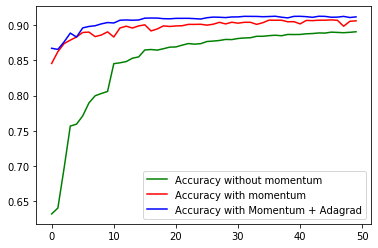

In [5]:
import matplotlib.pyplot as plt

plt.plot(range(len(model_no_momentum.accuracy_values)), model_no_momentum.accuracy_values,
         'g-', label = 'Accuracy without momentum')
plt.plot(range(len(model_momentum.accuracy_values)), model_momentum.accuracy_values,
         'r-', label = 'Accuracy with momentum')
plt.plot(range(len(model_momentum_adagrad.accuracy_values)), model_momentum_adagrad.accuracy_values,
         'b-', label = 'Accuracy with Momentum + Adagrad')
plt.legend(loc='best')
plt.show()



It is clearly seen that the curves of the momentum model fall earlier
This is due to the accumulation of momentum in the directions most often indicated by the gradient

The plot above, shows that at the beginning, there is a difference in Momentum/no-Momentum models accuracy.
Models which use Momentum algorithm, tend to get closer to convergence point, quicker than the one without momentum.

The best result is reached by the one with adaptive gradient modification.
A blue line is clearly visible at the top of our plot, almost from the beginning.

Now I'll compare our model with a Logistic Regression model from Scikit-Learn library
In order to quickly achieve high accuracy, we set the momentum_alpha parameter to 1, so that the formula
for the velocity in the momentum algorithm takes the form velocity = velocity0 * momentum_const + 1*gradient

In [6]:
import datetime
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression

now = datetime.datetime.now()
best_model = SGD_logistic_regression(n_epochs=1, learning_rate=0.12, momentum_const=0.90, adagrad=True, momentum_alpha=1)
best_model.fit(X_train_drop, y_train_drop)
pred = best_model.predict(X_test_drop)
print('timing: ', datetime.datetime.now() - now)
print('Our model accuracy: ', model_no_momentum.evaluate(y_test_drop, pred))

#Our models raining process includes normalization
normalizer = Normalizer()
X_train_drop = normalizer.fit_transform(X_train_drop, y_train_drop)
X_test_drop = normalizer.fit_transform(X_test_drop, y_test_drop)

now = datetime.datetime.now()
mod = LogisticRegression(max_iter=100)
mod.fit(X_train_drop, y_train_drop)
pred2 = mod.predict(X_test_drop)
print('timing: ', datetime.datetime.now() - now)
print('Scikit Learn Logistic Regression model accuracy: ', model_no_momentum.evaluate(y_test_drop, pred2))

timing:  0:00:04.564559
Our model accuracy:  0.9189600507292327
timing:  0:00:04.611633
Scikit Learn Logistic Regression model accuracy:  0.9222574508560558


In [7]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test_drop, pred)
print("Our model confusion matrix:\n", matrix)
matrix = confusion_matrix(y_test_drop, pred2)
print("Sklearn model confusion matrix:\n", matrix)

Our model confusion matrix:
 [[3577  385]
 [ 254 3669]]
Sklearn model confusion matrix:
 [[3642  320]
 [ 293 3630]]


The confusion matrices look alike, so there are no surprises in our predictions.

# Results
Our model reaches similar accuracy with only 1 epoch of training process.
Our timing is also close to the scikit-learn one.

Now we'll set n_epochs param as a some bigger number to check if we can get better accuracy.

In [8]:
now = datetime.datetime.now()
best_model = SGD_logistic_regression(n_epochs = 50, learning_rate=0.12, momentum_const=0.9, adagrad=True)
best_model.fit(X_train_drop, y_train_drop)
pred = best_model.predict(X_test_drop)
print('timing: ', datetime.datetime.now() - now)
print('Our model accuracy: ', model_no_momentum.evaluate(y_test_drop, pred))

timing:  0:01:32.904764
Our model accuracy:  0.9225110970196576


Now we can tell that, our classifier is close to it's limit, already with 1 epoch of running.
Using Momentum improvement, we are able to minimize the shaking caused by randomly chosen samples.
Additionally, adaptive gradient helps us to manipulate the learning rate, so infrequent features got extra boost.
This is extremely useful in sparse data sets, and our MNIST number-photos belong to this kind.(lots of empty/white pixels)

When completing the task I supported myself, with the knowledge read in the following publications,
https://ruder.io/optimizing-gradient-descent/
https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d

and on my trials, ups and downs :) 